# Bitcoin Prediction Using ARIMA and RNN-LSTM
## Please refer to the project report for details on results and observations

## Setup

In [275]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
import datetime
import pandas as pd

#from keras.models import Sequential

#from keras.layers import Dense, Activation

import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
coinbase=pd.read_csv('eth_clean_2.csv')

#cryptonewsonly=pd.read_csv('cryptonewscleanedallmagic.csv',encoding='iso-8859-1')

In [277]:
from datetime import datetime

def timestampToDateTime(timestamp):
    return datetime.fromtimestamp(timestamp)
#Not needed for our data since we already have it in date.
#coinbase['DateTime']=coinbase['Date'].apply(timestampToDateTime)

coinbase['DateTime'] = pd.to_datetime(coinbase['Date'])
coinbase.dtypes

Date                   object
Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj Close             float64
Volume                float64
GDP                   float64
inflation             float64
MoneySupply           float64
DateTime       datetime64[ns]
dtype: object

In [278]:
coinbase.drop('Date',axis=1,inplace=True) 

In [279]:
(coinbase.head())

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
0,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0,1.822470e+13,1.041462,11937.3,2015-08-07
1,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0,1.822470e+13,1.041462,11925.9,2015-08-08
2,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0,1.822470e+13,1.041462,11929.2,2015-08-09
3,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0,1.822470e+13,1.041462,11943.1,2015-08-10
4,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0,1.822470e+13,1.041462,11955.2,2015-08-11


In [280]:
coinbase.isna().sum()/coinbase.count()

Open           0.0
High           0.0
Low            0.0
Close          0.0
Adj Close      0.0
Volume         0.0
GDP            0.0
inflation      0.0
MoneySupply    0.0
DateTime       0.0
dtype: float64

In [281]:
(coinbase[coinbase['DateTime']=='2016'])

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
147,0.933712,0.954822,0.931442,0.948024,0.948024,206062.0,1.871500e+13,1.035269,12355.3,2016-01-01


In [282]:
timeindex=pd.DatetimeIndex(coinbase['DateTime'])

In [283]:
coinbase.set_index(timeindex, inplace=True)

In [284]:
(coinbase['2016'].head())

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
DateTime,,,,,,,,,,
2016-01-01,0.933712,0.954822,0.931442,0.948024,0.948024,206062.0,1.871500e+13,1.035269,12355.3,2016-01-01
2016-01-02,0.947401,0.969637,0.936560,0.937124,0.937124,255504.0,1.871500e+13,1.035269,12355.3,2016-01-02
2016-01-03,0.938430,0.991362,0.934313,0.971905,0.971905,407632.0,1.871500e+13,1.035269,12355.3,2016-01-03
2016-01-04,0.972045,0.976438,0.929835,0.954480,0.954480,346245.0,1.871500e+13,1.035269,12355.3,2016-01-04
2016-01-05,0.953147,0.970597,0.946543,0.950176,0.950176,219833.0,1.871500e+13,1.035269,12454.7,2016-01-05


<AxesSubplot:xlabel='DateTime'>

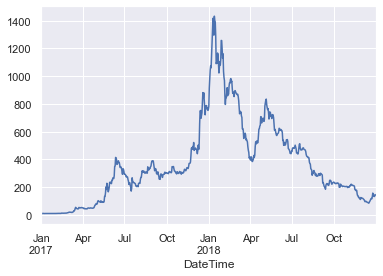

In [285]:
#sns.set(style="darkgrid")
import seaborn as sns; sns.set()
#sns.lineplot(x="Date", y="Close",
#             data=coinbase)

coinbase['2017':'2018']['High'].plot()

#coinbase['2017':'2018']['High'].resample(rule='T').plot()



DateTime
2017-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-09-29    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: BM, Name: High, dtype: object

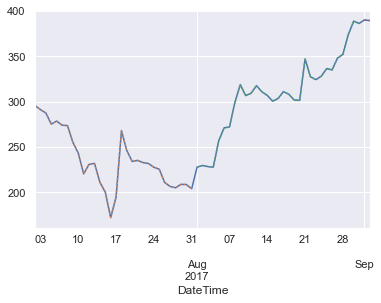

In [286]:
data=coinbase['2017-07-02':'2017-09-02']
data['High'].plot(style="-")
data['High'].resample('BM').plot(style=":")

In [287]:
def preprocess(dataframe):
    data=data.fillna(method='ffill')
    data=add_datepart(data, 'Date')
    return data

In [242]:
coinbase=coinbase.fillna(method='ffill')

In [243]:
coinbase.corr()

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply
Open,1.000000,0.998970,0.997875,0.997577,0.997577,0.639586,0.435662,0.469502,0.548146
High,0.998970,1.000000,0.997861,0.998997,0.998997,0.643304,0.432645,0.467633,0.545874
Low,0.997875,0.997861,1.000000,0.998746,0.998746,0.635172,0.439556,0.470189,0.553133
Close,0.997577,0.998997,0.998746,1.000000,1.000000,0.641419,0.435011,0.466966,0.549813
Adj Close,0.997577,0.998997,0.998746,1.000000,1.000000,0.641419,0.435011,0.466966,0.549813
Volume,0.639586,0.643304,0.635172,0.641419,0.641419,1.000000,0.634638,0.295453,0.803921
GDP,0.435662,0.432645,0.439556,0.435011,0.435011,0.634638,1.000000,0.756245,0.793418
inflation,0.469502,0.467633,0.470189,0.466966,0.466966,0.295453,0.756245,1.000000,0.477005
MoneySupply,0.548146,0.545874,0.553133,0.549813,0.549813,0.803921,0.793418,0.477005,1.000000


In [244]:
coinbase['PriceClose2D']=coinbase['Close']

In [245]:
shift=2 #  days
coinbase['PriceClose2D']=coinbase['PriceClose2D'].shift(-shift)
coinbase=coinbase[:-shift]

In [246]:
coinbase[73:90]

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2015-10-19,0.517621,0.521546,0.480994,0.489014,0.489014,243742.0,1.822470e+13,1.041462,12170.8,2015-10-19,0.447329
2015-10-20,0.489629,0.501898,0.431648,0.434829,0.434829,383921.0,1.822470e+13,1.041462,12230.2,2015-10-20,0.567702
2015-10-21,0.431589,0.482988,0.420897,0.447329,0.447329,609085.0,1.822470e+13,1.041462,12230.2,2015-10-21,0.539657
2015-10-22,0.444988,0.619466,0.420991,0.567702,0.567702,924822.0,1.822470e+13,1.041462,12230.2,2015-10-22,0.563590
2015-10-23,0.566370,0.611743,0.504284,0.539657,0.539657,878822.0,1.822470e+13,1.041462,12230.2,2015-10-23,0.616039
2015-10-24,0.539681,0.577396,0.518688,0.563590,0.563590,258356.0,1.822470e+13,1.041462,12230.2,2015-10-24,0.731317
2015-10-25,0.563207,0.688192,0.561383,0.616039,0.616039,635384.0,1.822470e+13,1.041462,12230.2,2015-10-25,0.869641
2015-10-26,0.619743,0.757517,0.597098,0.731317,0.731317,1089120.0,1.822470e+13,1.041462,12230.2,2015-10-26,1.002480
2015-10-27,0.708890,0.898172,0.708890,0.869641,0.869641,1846370.0,1.822470e+13,1.041462,12270.6,2015-10-27,1.206660


In [247]:
#Add_Datepart no longer in fastai but implementation found at: https://github.com/fastai/fastai_old/blob/master/dev_nb/x_009a_rossman_data_clean.ipynb
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [248]:
#add_datepart(coinbase,'DateTime')

In [249]:
coinbase['2015']

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0,1.822470e+13,1.041462,11937.3,2015-08-07,0.701897
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0,1.822470e+13,1.041462,11925.9,2015-08-08,0.708448
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0,1.822470e+13,1.041462,11929.2,2015-08-09,1.067860
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0,1.822470e+13,1.041462,11943.1,2015-08-10,1.217440
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0,1.822470e+13,1.041462,11955.2,2015-08-11,1.827670
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.853166,0.861538,0.841151,0.856365,0.856365,164565.0,1.822470e+13,1.041462,12368.6,2015-12-27,0.873054
2015-12-28,0.856356,0.872394,0.832932,0.845005,0.845005,235134.0,1.822470e+13,1.041462,12368.6,2015-12-28,0.911958
2015-12-29,0.843835,0.873054,0.833232,0.873054,0.873054,215742.0,1.822470e+13,1.041462,12355.3,2015-12-29,0.933542


In [250]:
coinbase.corr()

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,PriceClose2D
Open,1.000000,0.998956,0.997846,0.997526,0.997526,0.638783,0.436058,0.473003,0.545943,0.992632
High,0.998956,1.000000,0.997844,0.998982,0.998982,0.642484,0.432977,0.471064,0.543623,0.994265
Low,0.997846,0.997844,1.000000,0.998725,0.998725,0.634541,0.440237,0.474095,0.551141,0.993824
Close,0.997526,0.998982,0.998725,1.000000,1.000000,0.640711,0.435485,0.470584,0.547681,0.995181
Adj Close,0.997526,0.998982,0.998725,1.000000,1.000000,0.640711,0.435485,0.470584,0.547681,0.995181
Volume,0.638783,0.642484,0.634541,0.640711,0.640711,1.000000,0.634234,0.295279,0.803183,0.643317
GDP,0.436058,0.432977,0.440237,0.435485,0.435485,0.634234,1.000000,0.756287,0.793397,0.433917
inflation,0.473003,0.471064,0.474095,0.470584,0.470584,0.295279,0.756287,1.000000,0.477203,0.465315
MoneySupply,0.545943,0.543623,0.551141,0.547681,0.547681,0.803183,0.793397,0.477203,1.000000,0.551031
PriceClose2D,0.992632,0.994265,0.993824,0.995181,0.995181,0.643317,0.433917,0.465315,0.551031,1.000000


In [251]:
# Optional Step if you want to convert problem into classification problem and use a Deep ANN
# #coinbase['increaseAfterX']=coinbase['Close']-coinbase['PriceClose2H']
# #coinbase['increaseAfterX']=coinbase['increaseAfterX']>0
# coinbase['increaseAfterX']=coinbase.apply(lambda row:row['Close']-row['PriceClose2H']<0, axis=1).astype(int)b

# Training & Testing

## Model 1: RANDOM FOREST :|

In [253]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
coinbase

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,1.643290e+05,1.822470e+13,1.041462,11937.3,2015-08-07,0.701897
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,6.741880e+05,1.822470e+13,1.041462,11925.9,2015-08-08,0.708448
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,5.321700e+05,1.822470e+13,1.041462,11929.2,2015-08-09,1.067860
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,4.052830e+05,1.822470e+13,1.041462,11943.1,2015-08-10,1.217440
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1.463100e+06,1.822470e+13,1.041462,11955.2,2015-08-11,1.827670
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,2093.260742,2140.985352,2032.387695,2107.887207,2107.887207,2.888939e+10,2.143320e+13,2.000000,18548.7,2021-04-05,1971.077271
2021-04-06,2109.493164,2151.223389,2057.609131,2118.378906,2118.378906,2.922287e+10,2.143320e+13,2.000000,18548.7,2021-04-06,2088.573730
2021-04-07,2117.728516,2133.187500,1945.442139,1971.077271,1971.077271,3.611627e+10,2.143320e+13,2.000000,18548.7,2021-04-07,2072.108887


In [254]:
from sklearn.model_selection import train_test_split
trainColumns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'GDP', 'inflation',
             'MoneySupply']
predictColumn='PriceClose2D'
X=coinbase[trainColumns]
y=coinbase[predictColumn]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,shuffle=False)

In [255]:
train_error=[]
test_error=[]
minDepth=2
maxDepth=40
models=[]
for depth in range(minDepth,maxDepth,2):
    regr=RandomForestRegressor(max_depth=depth, random_state=0,n_estimators=100,verbose=2)
    regr.fit(X_train, y_train)
    models.append(regr)
    tr_error=math.sqrt(mean_squared_error(regr.predict(X_train),y_train))
    te_error=math.sqrt(mean_squared_error(regr.predict(X_test),y_test))
    test_error.append(te_error)
    train_error.append(tr_error)
    print (depth,tr_error,te_error)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


12 10.119219383220416 393.0866054099374
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


14 9.798984606043916 394.31044609330866
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


16 9.73523001808504 405.40940185318345
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building t

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


18 9.749829127381947 394.6394372743933
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building t

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 o

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


32 9.722518664980816 394.10438172213566
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [256]:
train_error

[59.646500637696136,
 23.77106261017468,
 17.217491301159182,
 12.90076443512501,
 10.90796874518819,
 10.119219383220416,
 9.798984606043916,
 9.73523001808504,
 9.749829127381947,
 9.802342096682798,
 9.725999233215376,
 9.73191627208917,
 9.721841678300198,
 9.722518664980816,
 9.722518664980816,
 9.722518664980816,
 9.722518664980816,
 9.722518664980816,
 9.722518664980816]

In [257]:
test_error

[546.3987770715888,
 385.831799943566,
 396.2453933088163,
 397.89158077584517,
 389.98801557392153,
 393.0866054099374,
 394.31044609330866,
 405.40940185318345,
 394.6394372743933,
 398.92540103055444,
 388.42929436181413,
 394.30496568191273,
 394.1128306589693,
 394.10438172213566,
 394.10438172213566,
 394.10438172213566,
 394.10438172213566,
 394.10438172213566,
 394.10438172213566]

1863

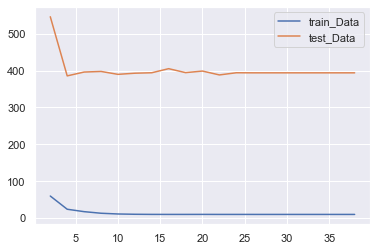

In [258]:
from sklearn.metrics import confusion_matrix
train_plot=pd.DataFrame(train_error,index=range(2,40,2),columns=["train_Data"])
test_plot=pd.DataFrame(test_error,index=range(2,40,2),columns=["test_Data"])
plotdata=pd.concat([train_plot,test_plot],axis=1)
plotdata.plot()
X_test.size

In [259]:
y_test.head()

DateTime
2020-09-12    377.268860
2020-09-13    364.839203
2020-09-14    365.812286
2020-09-15    389.019226
2020-09-16    384.364532
Name: PriceClose2D, dtype: float64

# Model 2: ARIMA MODEL :)

In [264]:
arima2015hour=coinbase['2015':'2020'].resample('D').mean().fillna(method='ffill')['Close']


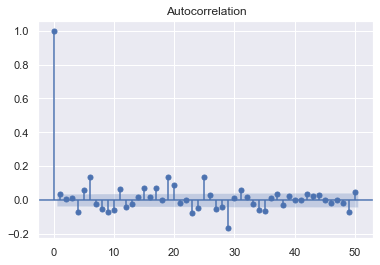

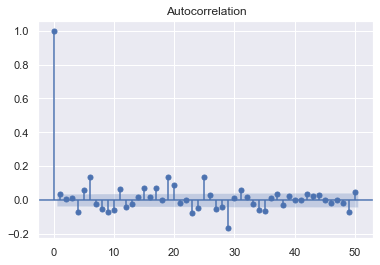

In [265]:
from statsmodels.graphics.tsaplots import plot_acf
#hourarim=arima2015hour.resample('H').mean()['Close']
plot_acf(arima2015hour.diff().dropna(), lags= 50, alpha=0.1)
#arima2015hour['Close'].pct_change().autocorr()
#dayarima.diff()
#arima2015hour.dropna().diff().plot()

In [266]:
from statsmodels.tsa.stattools import adfuller
adfuller(arima2015hour)[1]

0.26004769750506807

In [267]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
train,test = train_test_split(arima2015hour,test_size=0.24,shuffle=False)
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(arima2015hour, order=(4, 4))
result = mod.fit()

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARMA(history,order=(5,1))
    model_fit = mod.fit()
    yhat = model_fit.forecast()
    yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(yhat_p)
    # observation
    obs = test[i] 
    history.append(obs)
    print(str(yhat_p)+' '+' '+ str(history[-4:])+' '+str(obs)+' '+str(i)+' ')


188.56670547017586  [181.016098, 181.109726, 188.105515, 189.789124] 189.789124 0 
189.15865844488283  [181.109726, 188.105515, 189.789124, 197.113174] 197.113174 1 
197.25786483263585  [188.105515, 189.789124, 197.113174, 208.608749] 208.608749 2 
209.37588282856728  [189.789124, 197.113174, 208.608749, 211.393036] 211.393036 3 
212.29805401494232  [197.113174, 208.608749, 211.393036, 221.280853] 221.280853 4 
220.88856543696744  [208.608749, 211.393036, 221.280853, 218.05004900000003] 218.05004900000003 5 
216.77479483846017  [211.393036, 221.280853, 218.05004900000003, 215.516205] 215.516205 6 
215.5662251114304  [221.280853, 218.05004900000003, 215.516205, 211.54538] 211.54538 7 
211.70284654551438  [218.05004900000003, 215.516205, 211.54538, 201.92131] 201.92131 8 
202.35962820862972  [215.516205, 211.54538, 201.92131, 168.110733] 168.110733 9 
166.78132434510593  [211.54538, 201.92131, 168.110733, 170.8927] 170.8927 10 
170.2185099787041  [201.92131, 168.110733, 170.8927, 166.727

In [268]:
pd.concat([pd.DataFrame(predictions,index=test.index,columns=['predictions']),test],axis=1)

,predictions,Close
DateTime,,
2019-09-15,188.566705,189.789124
2019-09-16,189.158658,197.113174
2019-09-17,197.257865,208.608749
2019-09-18,209.375883,211.393036
2019-09-19,212.298054,221.280853
...,...,...
2020-12-27,641.425431,682.642334
2020-12-28,682.768798,730.397339
2020-12-29,728.225484,731.520142


In [269]:
error=math.sqrt(mean_squared_error(test,predictions))
error

13.88989019826746

In [270]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(arima2015hour, order=(4,4))
result = mod.fit()

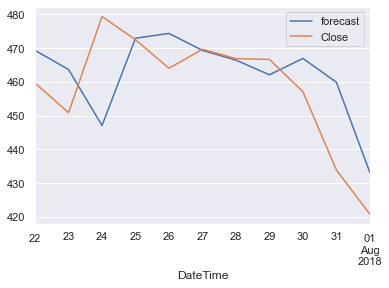

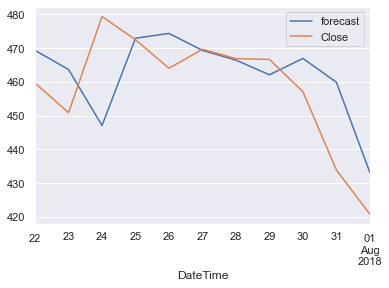

In [271]:
result.plot_predict(start=1080,end=1090)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1974
Model:                     ARMA(4, 4)   Log Likelihood               -8599.698
Method:                       css-mle   S.D. of innovations             18.843
Date:                Mon, 26 Apr 2021   AIC                          17219.396
Time:                        21:57:17   BIC                          17275.274
Sample:                    08-07-2015   HQIC                         17239.927
                         - 12-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         265.1237    143.081      1.853      0.064     -15.311     545.558
ar.L1.Close     0.9377      0.169      5.546      0.000       0.606       1.269
ar.L2.Close    -0.5387      0.235     -2.293    

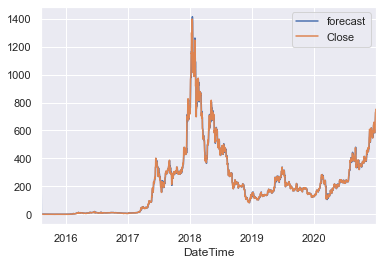

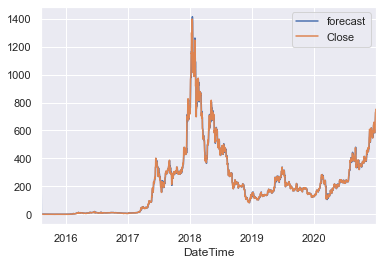

In [272]:
print(result.summary())
result.plot_predict()

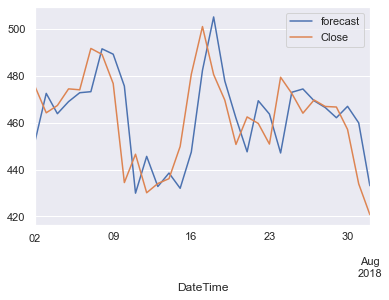

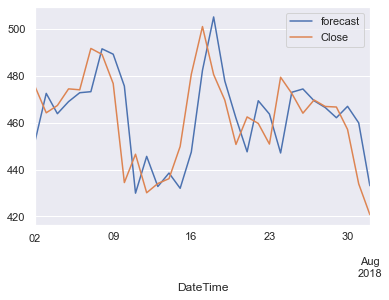

In [273]:
result.plot_predict(start=1060, end=1090)

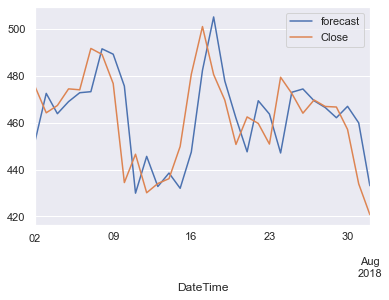

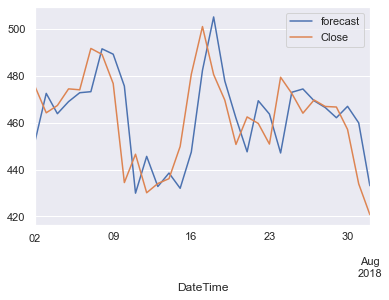

In [274]:
result.plot_predict(start=1060, end=1090)